# Single Source Shortest Path
__`Guangyu (Gary) Pei| guangyu.pei@berkeley.edu`__

__Objectives:__

- Implement Single Source Shortest Path (SSSP) in Spark using RDDs.
- Describe implementation steps in Spark using DataFrames.
- Discuss whether there is a `GraphFrames` implementation to compare/contrast.
- Discuss how to implement Longest Path and the challenges.

## Table of Contents

[Google Clound Platform and Local Jupyter Notebook Setup](#Notebook-Set-Up)

[Introduction](#Introduction)

[SSSP Implementation](#SSSP-Implementation)

[DataFrames implementation sketch](#DataFrames-implementation-sketch)

[GraphFrames Shortest Path](#GraphFrames-shortest-path)

[Longest Path](#Longest-Path)

[Summary and conclusion](#Summary-and-conclusion)

# Notebook Set-Up

In [1]:
#GCP Cluster Only
spark

In [2]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "EC"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [5]:
# GCP Cluster Only
sc = spark.sparkContext
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
sc.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.yarn.historyServer.address', 'w261-ec-m:18080'),
 ('spark.app.id', 'application_1553571873267_0001'),
 ('spark.repl.local.jars',
  'file:///root/.ivy2/jars/graphframes_graphframes-0.7.0-spark2.3-s_2.11.jar,file:///root/.ivy2/jars/org.slf4j_slf4j-api-1.7.16.jar'),
 ('spark.driver.appUIAddress', 'http://w261-ec-m.c.w261-233219.internal:4040'),
 ('spark.yarn.am.memory', '640m'),
 ('spark.executor.cores', '4'),
 ('spark.executorEnv.PYTHONPATH',
  '/usr/lib/spark/python/:/usr/lib/spark/python/lib/py4j-0.10.7-src.zip<CPS>{{PWD}}/pyspark.zip<CPS>{{PWD}}/py4j-0.10.7-src.zip<CPS>{{PWD}}/graphframes_graphframes-0.7.0-spark2.3-s_2.11.jar<CPS>{{PWD}}/org.slf4j_slf4j-api-1.7.16.jar'),
 ('spark.yarn.dist.jars',
  'file:///root/.ivy2/jars/graphframes_graphframes-0.7.0-spark2.3-s_2.11.jar,file:///root/.ivy2/jars/org.slf4j_slf4j-api-1.7.16.jar'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFil

# Introduction

In this example, I will implement Single Source Shortest Path (SSSP) algorithm in Spark. The data set is the Wikipedia dataset. It is a 2GB
subset of a 500GB dataset released by AWS in 2009. The data includes the source and metadata for all of the Wikimedia wikis.
The description of the data can be found at https://aws.amazon.com/blogs/aws/new-public-data-set-wikipedia-xml-data.

To make it challenge and use this data as weighted direct graph, the interpretation of the value in dictionary is different. Instead of treating the value as the number of times the linked page is visited, the value is considered as the weight to the linked page. As shown below, the data were downloaded and loaded in RDD.

In [5]:
# create a data directory
!mkdir data

In [6]:
# download the test data set
!wget -q -O data/test_graph.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AACf_33TeM7rKfEhjEoNmMCaa/PageRank-test_indexed.txt?dl=0

In [5]:
# take a look
!cat data/test_graph.txt

2	{'3': 1}
3	{'2': 1}
4	{'1': 1, '2': 1}
5	{'4': 1, '2': 1, '6': 1}
6	{'2': 1, '5': 1}
7	{'2': 1, '5': 1}
8	{'2': 1, '5': 1}
9	{'2': 1, '5': 1}
10	{'5': 1}
11	{'5': 1}


In [9]:
# download the main data set
!wget -O data/wiki_graph.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt?dl=0

--2019-03-17 18:20:46--  https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt?dl=0
Resolving www.dropbox.com... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt [following]
--2019-03-17 18:20:46--  https://www.dropbox.com/sh/raw/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd4786f0b10c00dc594f41b81d8.dl.dropboxusercontent.com/cd/0/inline/AdQHHlKwkpbWil3a7HCxNcWZatWB3Gffd2-rBS_yLZwnVtzuGqWq9undMcZcqb4hDdK291uTqNPi4yxuZ9rMV-a9YonyrlfzLVWYwN8mjMqUiQpS4CHfJn4UgyMMol5Z5-4/file# [following]
--2019-03-17 18:20:47--  https://ucd4786f0b10c00dc594f41b81d8.dl.dropboxusercontent.com/cd/0/in

In [6]:
# take a look
!head data/wiki_graph.txt

73	{'14417532': 1}
299	{'4214575': 1}
2552	{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}
2570	{'983991': 1}
2616	{'9045350': 1}
2711	{'752887': 1}
2818	{'3534183': 1}
2847	{'3797918': 1}
2892	{'2893': 1}
2921	{'5158607': 1, '6007184': 1, '14773825': 1, '11777840': 2, '9285165': 1, '6420484': 1, '14670682': 1, '7316613': 1, '7125893': 1, '14965920': 1, '14229952': 1, '9447742': 2, '1425342': 1, '11390944': 2, '5141': 1, '14928135': 2, '13636570': 3, '14687433': 1, '15105458': 1, '11656072': 1, '6420027': 1, '10898196': 1, '6416278': 1, '11497740': 2}


In [147]:
# load the data into Spark RDDs for convenience of use later
testRDD = sc.textFile('data/test_graph.txt')
toyRDD = sc.textFile('data/toy_graph.txt')
wikiRDD = sc.textFile('data/wiki_graph.txt')

In [6]:
# For GCP cluster only
testRDD = sc.textFile('gs://w261-data-gp/data/test_graph.txt')
wikiRDD = sc.textFile('gs://w261-data-gp/data/wiki_graph.txt')

# SSSP Implementation

![alt text](Dijkstra_Animation.gif)

The Dijkstra's algorithm is the well known algorithm of finding the shortest path for weighted graph. The above animation illustrats the algorithm. It is a BFS tranversal algorithm using priority queue to keep track of the frontier nodes from iteration to iteration. In order to implement this in a distributed parallel computing environment with map and reduce, we have to avoid the global priority queue. Thus, we need to define node states and keep track of them distributely. To this end, each node can be in one of the following state to identify its status of traversing the graph:
  - Visited
  - Queue
  - Unvisited

First, I initialize the graph with records in the form of `node_id (edges, distance_from_source, path_from_source, state)`. The source node will be initialized with distance 0 and path is the source node itself. The state of source node is `Q`, namely, the source node is initialized as the frontier node. All the other nodes are initialized with distance infinity to the source node and state of `U`, unvisited state. The initialization function is shown below.

### SSSP: Initialize the Graph

In [7]:
def initGraph(dataRDD, sourceID):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node, initial distance to sourceID, and graph traversal state.
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (out_nodes, distance, path, state))
    """
    # helper functions
    def parse(line):
        node, edges = line.split('\t')
        edges = ast.literal_eval(edges)
        if (node != sourceID):
            yield (node, (edges, np.Inf, [], 'U'))
        else:
            yield (node, (edges, 0, [node], 'Q'))
    # main Spark code
    graphRDD = dataRDD.flatMap(parse).cache()
    return graphRDD

In [42]:
start = time.time()
testGraph = initGraph(testRDD, '4' ).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph

... test graph initialized in 0.10717988014221191 seconds.


[('2', ({'3': 1}, inf, [], 'U')),
 ('3', ({'2': 1}, inf, [], 'U')),
 ('4', ({'1': 1, '2': 1}, 0, ['4'], 'Q')),
 ('5', ({'4': 1, '2': 1, '6': 1}, inf, [], 'U')),
 ('6', ({'2': 1, '5': 1}, inf, [], 'U')),
 ('7', ({'2': 1, '5': 1}, inf, [], 'U')),
 ('8', ({'2': 1, '5': 1}, inf, [], 'U')),
 ('9', ({'2': 1, '5': 1}, inf, [], 'U')),
 ('10', ({'5': 1}, inf, [], 'U')),
 ('11', ({'5': 1}, inf, [], 'U'))]

In [8]:
wikiGraphRDD = initGraph(wikiRDD, '13455888').cache()
print(wikiGraphRDD.take(5))

[('73', ({'14417532': 1}, inf, [], 'U')), ('299', ({'4214575': 1}, inf, [], 'U')), ('2552', ({'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}, inf, [], 'U')), ('2570', ({'983991': 1}, inf, [], 'U')), ('2616', ({'9045350': 1}, inf, [], 'U'))]


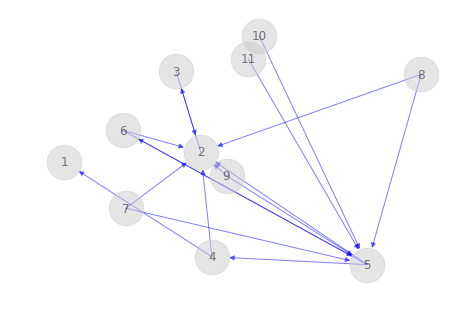

In [186]:
def plotTestGraph(rdd, positions = None, nz=1200, ec='b', nc="#cccccc"):
    nodes = set()
    edges = []
    graph= rdd.collect()
    for line in graph:
        n, e = line.split('\t')
        e = ast.literal_eval(e)
        nodes.add(n)
        for k,v in e.items():
            edges.append((n,k,v))
    nodes = list(nodes)
    G=nx.DiGraph()
    for n in nodes:
        G.add_node(n)
    for e in edges:
        G.add_edge(e[0],e[1],weight=e[2])
    if (not positions):
        positions = nx.random_layout(G)
    nx.draw(G, pos=positions, with_labels=True, alpha = 0.5, node_size = nz, edge_color = ec, node_color=nc )

plotTestGraph(testRDD)

### Implement SSSP using RDDs

For maximum parallelism, the Maps and Reduces to be stateless. Also, you cannot control the order in which the maps run, or the reductions.

The Mappers are to expand the “frontier” during each iteration. For each frontier node, the Mappers emit list of new frontier nodes
tagged with state Queue, and distance = distance + edge weight. Old frontier updated to Visited state. Mappers emit all “unvisited nodes”
as Unvisited state, with no change.

The Reducers are to merge candidate paths. The SSSP reducers receive all data for a given key and combine as new key-value pair for
next iteration.

The detailed desciption of the distributed Dijkstra algorithm implementation is given below.

   -  __Mapper Function__
   
         * Emit list of new frontier nodes tagged with `Q`, distance = distance + weight and path = path + current node.
         * Mappers tag down stream edges from new frontier nodes as `Null` since mappers do not know them. 
         * Old frontier (namely state with `Q`) updated to visited `V`.
         * Emit all nodes with `U` or `V` as is.


   -  __Reducer Function__
   
         * The SSSP reducers receive all data for a given key
         * They receive the Null "copies" from newly expanded frontier nodes 
         * They also receive info on down stream nodes for that key
         * The reducers combine as new key-value pair for next cycle.
             - Out_nodes: Union all values
             - Distance: Take the min
             - Path: Take the path that corresponds to min distance
             - State:
                 Weighted Graph:
                  * if Q, V and distance(Q) < distance(V):
                      - new_state = Q
                  * else:
                      - new_state = V
                  * if Q, U:
                      - new_state = Q
                  * if V, U:
                      - new_state = V

The implementation that matches with the above description is the following function named `Dijkstra()`.

In [9]:
def Dijkstra(initGraphRDD, verbose = True):
    accum_Qstate = sc.accumulator(0)
    # helper function
    def update_Qstate_counter(x):
        if (x[1][3] == 'Q'):
            accum_Qstate.add(1)
    def mapper(x):
        if (x[1][3] == 'U' or x[1][3] == 'V'):
            yield x
        else: # Q state
            yield x[0], (x[1][0], x[1][1], x[1][2], 'V')
            for k,v in x[1][0].items():
                if (x[1][2]):
                    yield k, ({}, x[1][1] + v, x[1][2] + [k] , 'Q')
                else:
                    yield k, ({}, x[1][1] + v, [k], 'Q')
    def reducer(x, y):
        """Weighted Graph:
          if Q,V and distance(Q) < distance(V):    new_state = Q
            else:    new_state = V
          if Q,U:    new_state = Q """
        out_nodes = {**x[0], **y[0]}
        if (x[1] <= y[1]):
            dist = x[1]
            path = x[2]
        else:
            dist = y[1]
            path = y[2]
        if (x[3] == y[3]):
            state = x[3]
        elif (x[3] == 'V' and y[3] == 'Q'):
            if (y[1] < x[1]):
                state = 'Q'
            else:
                state = 'V'
        elif (x[3] == 'Q' and y[3] == 'V'):
            if (x[1] < y[1]):
                state = 'Q'
            else:
                state = 'V'
        elif ((x[3] == 'Q' and y[3] == 'U') or (x[3] == 'U' and y[3] == 'Q')):
            state = 'Q'
        elif ( (x[3] == 'V' and y[3] == 'U') or (x[3] == 'U' and y[3] == 'V')):
            state = 'V'
        return (out_nodes, dist, path, state)
           
            
    # main spark code
    rdd = initGraphRDD
    rdd.foreach(update_Qstate_counter)
    iteration = 0
    while (accum_Qstate.value):
        rdd = rdd.flatMap(mapper).reduceByKey(reducer).cache()
        accum_Qstate.value = 0
        rdd.foreach(update_Qstate_counter)
        if (verbose):
            iteration += 1
            print(f"At the end of iteration {iteration}, number of frontier nodes is {accum_Qstate.value}.")
    return rdd

#### SSSP implementation testing

To validate the implementation with several test data, I also provide the helper function named `compare_with_nx` for comparing with `NetworkX` results. The function is given below.

In [176]:
def compare_with_nx(results, sourceID, method = 'RDD'):
    nodes = set()
    edges = []
    print('='*20+'Results from '+ method +'='*20)
    for line in results:
        (n, x) = line
        nodes.add(n)
        for k,v in x[0].items():
            edges.append((n,k,v))
        if (x[3] == 'V'):
            print(f'{sourceID}->{n}: distance={x[1]}, path={x[2]}')
    print('='*20+'Results from NetworkX'+'='*20)
    nodes = list(nodes)
    G = nx.DiGraph()
    for node in nodes:
        G.add_node(node)
    for edge in edges:
        G.add_edge(edge[0],edge[1],weight=edge[2])
    print("lenghts",nx.single_source_dijkstra_path_length(G,sourceID) )
    print("paths",nx.single_source_dijkstra_path(G, sourceID) )
    print('='*80)

**Test with Example A**

The following is the test for the test graph we mentioned earlier. The output from `NetworkX` matches with the implementation.

In [178]:
testGraph = initGraph(testRDD, '4' )
test_results = Dijkstra(testGraph, verbose = True).collect()
compare_with_nx(test_results, '4')

At the end of iteration 1, number of frontier nodes is 2.
At the end of iteration 2, number of frontier nodes is 1.
At the end of iteration 3, number of frontier nodes is 0.
====================Results from RDD====================
4->4: distance=0, path=['4']
4->1: distance=1, path=['4', '1']
4->2: distance=1, path=['4', '2']
4->3: distance=2, path=['4', '2', '3']
====================Results from NetworkX====================
lenghts {'4': 0, '1': 1, '2': 1, '3': 2}
paths {'4': ['4'], '1': ['4', '1'], '2': ['4', '2'], '3': ['4', '2', '3']}


**Test with Example B**

At the end of iteration 1, number of frontier nodes is 2.
At the end of iteration 2, number of frontier nodes is 2.
At the end of iteration 3, number of frontier nodes is 0.
====================Results from RDD====================
A->C: distance=5, path=['A', 'B', 'C']
A->B: distance=1, path=['A', 'B']
A->D: distance=3, path=['A', 'B', 'D']
A->A: distance=0, path=['A']
A->E: distance=5, path=['A', 'E']
====================Results from NetworkX====================
lenghts {'A': 0, 'B': 1, 'D': 3, 'E': 5, 'C': 5}
paths {'A': ['A'], 'B': ['A', 'B'], 'E': ['A', 'E'], 'C': ['A', 'B', 'C'], 'D': ['A', 'B', 'D']}


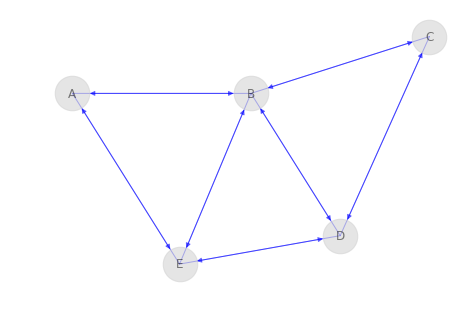

In [187]:
pos = {  'A': [-1.0,  0.2],
         'B': [ 0.0,  0.2],
         'C': [ 1.0,  0.4],
         'D': [ 0.5, -0.3],
         'E': [-0.4, -0.4]}
plotTestGraph(toyRDD, positions = pos)
toyGraph = initGraph(toyRDD, 'A' )
toy_results = Dijkstra(toyGraph, verbose = True).collect()
compare_with_nx(toy_results, 'A')

**Test with Example C**

As shown below, this is an interesting test case as nodes `n6` to `n9` have to update their state, distance and path before the Dijkstra algorithm completes.

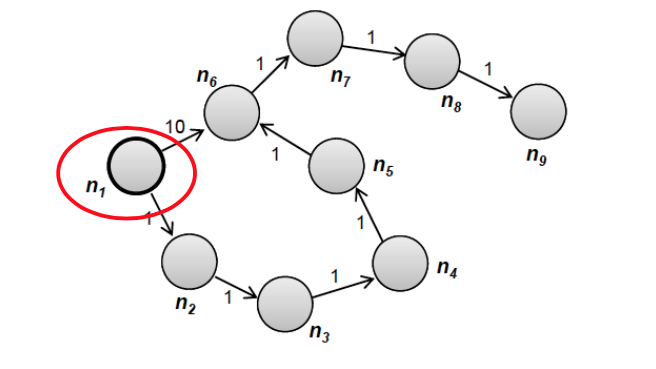

In [188]:
from IPython.display import Image
Image('data/sssp_quiz.png')

In [190]:
ssspQuizRDD = sc.textFile('data/sssp_quiz.txt')
ssspQuizGraph = initGraph(ssspQuizRDD, 'n1' )
ssspQuiz_results = Dijkstra(ssspQuizGraph, verbose = True).collect()
compare_with_nx(ssspQuiz_results, 'n1')

At the end of iteration 1, number of frontier nodes is 2.
At the end of iteration 2, number of frontier nodes is 2.
At the end of iteration 3, number of frontier nodes is 2.
At the end of iteration 4, number of frontier nodes is 2.
At the end of iteration 5, number of frontier nodes is 1.
At the end of iteration 6, number of frontier nodes is 1.
At the end of iteration 7, number of frontier nodes is 1.
At the end of iteration 8, number of frontier nodes is 1.
At the end of iteration 9, number of frontier nodes is 0.
====================Results from RDD====================
n1->n1: distance=0, path=['n1']
n1->n4: distance=3, path=['n1', 'n2', 'n3', 'n4']
n1->n5: distance=4, path=['n1', 'n2', 'n3', 'n4', 'n5']
n1->n8: distance=7, path=['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8']
n1->n9: distance=8, path=['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
n1->n6: distance=5, path=['n1', 'n2', 'n3', 'n4', 'n5', 'n6']
n1->n7: distance=6, path=['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7']

As shown above, the results from my implementation matches with `networkX` in all test cases. 

Now, it is ready to find SSSP with Wikipedia dataset. I used both GCP and a local machine run the SSSP and outputs are given below.

The source node is the `13455888`, which is the highest PageRank node I found in my PageRank implementation. It calculates the SSSP from source to all nodes. The shortest path from source `13455888` to destination `4695850` is given as example.

In [10]:
start = time.time()
wiki_sssp = Dijkstra(wikiGraphRDD, verbose = True).cache()
print(f'... wiki sssp (rdd implementation) completed in {time.time() - start} seconds.')

At the end of iteration 1, number of frontier nodes is 1257.
At the end of iteration 2, number of frontier nodes is 138272.
At the end of iteration 3, number of frontier nodes is 2070921.
At the end of iteration 4, number of frontier nodes is 5745275.
At the end of iteration 5, number of frontier nodes is 4179030.
At the end of iteration 6, number of frontier nodes is 1235326.
At the end of iteration 7, number of frontier nodes is 267354.
At the end of iteration 8, number of frontier nodes is 48797.
At the end of iteration 9, number of frontier nodes is 12903.
At the end of iteration 10, number of frontier nodes is 3746.
At the end of iteration 11, number of frontier nodes is 1445.
At the end of iteration 12, number of frontier nodes is 774.
At the end of iteration 13, number of frontier nodes is 805.
At the end of iteration 14, number of frontier nodes is 318.
At the end of iteration 15, number of frontier nodes is 162.
At the end of iteration 16, number of frontier nodes is 130.
At t

**The following is the result from single standalone machine.**
```
At the end of iteration 1, number of frontier nodes is 1257.
At the end of iteration 2, number of frontier nodes is 138272.
At the end of iteration 3, number of frontier nodes is 2070921.
At the end of iteration 4, number of frontier nodes is 5745275.
At the end of iteration 5, number of frontier nodes is 4179030.
At the end of iteration 6, number of frontier nodes is 1235326.
At the end of iteration 7, number of frontier nodes is 267354.
At the end of iteration 8, number of frontier nodes is 48797.
At the end of iteration 9, number of frontier nodes is 12903.
At the end of iteration 10, number of frontier nodes is 3746.
At the end of iteration 11, number of frontier nodes is 1445.
At the end of iteration 12, number of frontier nodes is 774.
At the end of iteration 13, number of frontier nodes is 805.
At the end of iteration 14, number of frontier nodes is 318.
At the end of iteration 15, number of frontier nodes is 162.
At the end of iteration 16, number of frontier nodes is 130.
At the end of iteration 17, number of frontier nodes is 143.
At the end of iteration 18, number of frontier nodes is 160.
At the end of iteration 19, number of frontier nodes is 124.
At the end of iteration 20, number of frontier nodes is 88.
At the end of iteration 21, number of frontier nodes is 67.
At the end of iteration 22, number of frontier nodes is 46.
At the end of iteration 23, number of frontier nodes is 31.
At the end of iteration 24, number of frontier nodes is 27.
At the end of iteration 25, number of frontier nodes is 15.
At the end of iteration 26, number of frontier nodes is 14.
At the end of iteration 27, number of frontier nodes is 10.
At the end of iteration 28, number of frontier nodes is 12.
At the end of iteration 29, number of frontier nodes is 11.
At the end of iteration 30, number of frontier nodes is 7.
At the end of iteration 31, number of frontier nodes is 8.
At the end of iteration 32, number of frontier nodes is 7.
At the end of iteration 33, number of frontier nodes is 8.
At the end of iteration 34, number of frontier nodes is 9.
At the end of iteration 35, number of frontier nodes is 10.
At the end of iteration 36, number of frontier nodes is 6.
At the end of iteration 37, number of frontier nodes is 2.
At the end of iteration 38, number of frontier nodes is 1.
At the end of iteration 39, number of frontier nodes is 1.
At the end of iteration 40, number of frontier nodes is 1.
At the end of iteration 41, number of frontier nodes is 1.
At the end of iteration 42, number of frontier nodes is 1.
At the end of iteration 43, number of frontier nodes is 2.
At the end of iteration 44, number of frontier nodes is 1.
At the end of iteration 45, number of frontier nodes is 1.
At the end of iteration 46, number of frontier nodes is 1.
At the end of iteration 47, number of frontier nodes is 1.
At the end of iteration 48, number of frontier nodes is 1.
At the end of iteration 49, number of frontier nodes is 1.
At the end of iteration 50, number of frontier nodes is 1.
At the end of iteration 51, number of frontier nodes is 1.
At the end of iteration 52, number of frontier nodes is 1.
At the end of iteration 53, number of frontier nodes is 1.
At the end of iteration 54, number of frontier nodes is 1.
At the end of iteration 55, number of frontier nodes is 1.
At the end of iteration 56, number of frontier nodes is 1.
At the end of iteration 57, number of frontier nodes is 1.
At the end of iteration 58, number of frontier nodes is 1.
At the end of iteration 59, number of frontier nodes is 1.
At the end of iteration 60, number of frontier nodes is 2.
At the end of iteration 61, number of frontier nodes is 1.
At the end of iteration 62, number of frontier nodes is 1.
At the end of iteration 63, number of frontier nodes is 1.
At the end of iteration 64, number of frontier nodes is 1.
At the end of iteration 65, number of frontier nodes is 4.
At the end of iteration 66, number of frontier nodes is 4.
At the end of iteration 67, number of frontier nodes is 3.
At the end of iteration 68, number of frontier nodes is 3.
At the end of iteration 69, number of frontier nodes is 1.
At the end of iteration 70, number of frontier nodes is 1.
At the end of iteration 71, number of frontier nodes is 1.
At the end of iteration 72, number of frontier nodes is 1.
At the end of iteration 73, number of frontier nodes is 0.
... wiki sssp (rdd implementation) completed in 10437.99913930893 seconds.
```

In [11]:
start = time.time()
result_dest_4695850 = wiki_sssp.filter(lambda x: x[0] == '4695850').collect()
print(f'Distance to 4695850: {result_dest_4695850[0][1][1]}, path {result_dest_4695850[0][1][2]}')
print(f'... wiki sssp (rdd implementation) get path from source 13455888 to destination 4695850: {time.time() - start} seconds.')

Distance to 4695850: 2, path ['13455888', '1054645', '4695850']
... wiki sssp (rdd implementation) get path from source 13455888 to destination 4695850: 5.996818780899048 seconds.


**The following is the result from single standalone machine.**
```
Distance to 4695850: 2, path ['13455888', '1059632', '4695850']
... wiki sssp (rdd implementation) get path from source 13455888 to destination 4695850: 37.7335045337677 seconds.
```

# DataFrames implementation sketch

In the following, the DataFrame implementation description is given.

First, the data will be read as DataFrame as shown below. The DataFrame is initialized by adding SSSP required information as new column.

In [7]:
from pyspark.sql.functions import split
from pyspark.sql.functions import udf, col
from pyspark.sql import types

def data_to_df(file):
    ret = spark.read.text(file).withColumnRenamed('value', 'nbrs')
    ret = ret.withColumn('node', split(ret.nbrs, '\t')[0]).withColumn('edges', split(ret.nbrs, '\t')[1]).drop('nbrs')
    return ret

def initGraphDF(df, sourceID):
    schema = types.StructType([
    types.StructField("dist", types.IntegerType()),
    types.StructField("state", types.StringType()),
    types.StructField("path", types.ArrayType(types.StringType()))])
    
    def sssp(node):
        if (node == sourceID):
            return (0, 'Q', [node])
        else:
            return (np.iinfo(np.int32).max,'U', [])
    sssp = udf(sssp, schema)
    df = df.select('node', 'edges', sssp(col('node')).alias('sssp'))
    return df

In [77]:
toyDF = initGraphDF(data_to_df('data/toy_graph.txt'), 'B')
toyDF.show()
toyDF.printSchema()

+----+--------------------+-------------------+
|node|               edges|               sssp|
+----+--------------------+-------------------+
|   A|    {'B': 1, 'E': 5}|[2147483647, U, []]|
|   B|{'A': 2, 'C': 4, ...|        [0, Q, [B]]|
|   C|    {'B': 5, 'D': 2}|[2147483647, U, []]|
|   D|{'B': 7, 'C': 3, ...|[2147483647, U, []]|
|   E|{'A': 4, 'B': 1, ...|[2147483647, U, []]|
+----+--------------------+-------------------+

root
 |-- node: string (nullable = true)
 |-- edges: string (nullable = true)
 |-- sssp: struct (nullable = true)
 |    |-- dist: integer (nullable = true)
 |    |-- state: string (nullable = true)
 |    |-- path: array (nullable = true)
 |    |    |-- element: string (containsNull = true)



In [78]:
toyDF.filter(toyDF.sssp.state == 'Q').count()

1

The key idea of implementing distributed SSSP remains the same as using RDDs. I plan do the following to implement SSSP with DataFrames.

- Use a broadcast count to keep track of total number of nodes in `Q` state and the algorithm stops when the count reaches 0.
- During each iteration:
    * mapper function will expand data frame with rows for all nodes in `Q` state. It will change nodes in `Q` state to `V` state.
    * reducer function will reduce the data frame by node ID field and update column `sssp` in the same way as in the case of RDD.

# GraphFrames shortest path

GraphFrames does has implementation of shortest path. However, its has different input and output formats.

For inputs, dataframes of nodes and edges are required. For node dataframe, a column with name `id` is required. For edge dataframe, it requires columns named `src` and `dst`. However, these is no weights on the edges. Thus, the shortest path is for unweighted graph.

In terms of output, it provides the shortest path to set of landmark nodes from every node. Thus, it is not single source shortest path. It is the shortest path from all nodes to set of destinations. Thus, it is not the same as SSSP. Finally, GraphFrames only provide the result for distance and there is no path output.

To show this, I provided the code below using the same toy example used in [week 9 live session demo notebook](https://github.com/UCB-w261/main/blob/master/LiveSessionMaterials/wk09Demo_Graphs/master/demo9_workbook.ipynb). First, I align the data input with the required GraphFrames format. The distances to landmark node `D` are provided.

In [6]:
from graphframes import *

In [51]:
def create_graph_frame(rdd):
    def parse(line):
        node, edges = line.split('\t')
        edges = ast.literal_eval(edges)
        e = []
        for k in edges.keys():
            e.append([node, k])
        yield (node, e)
    def emit_edges(x):
        for e in x[1]:
            yield e
    rdd = rdd.flatMap(parse).cache()
    ndf = rdd.map(lambda x: (x[0], )).toDF(['id'])
    edf = rdd.flatMap(emit_edges).toDF(['src','dst'])
    g = GraphFrame(ndf, edf)
    return g

In [56]:
toygf = create_graph_frame(sc.textFile('gs://w261-data-gp/data/toy_graph.txt'))
toygf.shortestPaths(landmarks=["D"]).select("id", "distances").show()

+---+---------+
| id|distances|
+---+---------+
|  D| [D -> 0]|
|  E| [D -> 1]|
|  C| [D -> 1]|
|  B| [D -> 1]|
|  A| [D -> 2]|
+---+---------+



Thus, the implementation of shortest path from GraphFrames cannot be used due to its setup, unweighted edges and no actual path output (only distance value).

# Longest Path

First, we have to define the longest path a little more concise. In particular, the longest path must be simple path, which means that there is no repeated vertices along the path. Also the graph has to be Directed Acyclic Graphs (DAG) in order to have a polynomial complexity otherwise it is known that the longest path problem is a NP-complete problem.

When we are constrained to solve the longest path for DAG, we can transform it to a shortest path problem by negating the weights (we also assume that the original graph has positive weights here). Thus, we can apply the SSSP here. The challenge is that we have to ensure the graph is DAG otherwise it will not be able converge.

# Summary and conclusion

In this assignment, I implemented SSSP using RDD.  I used Wikipedia dataset to calculate the shortest path from single source to all reachable destinations with both GCP cluster and local multi-core standalone machine. The implementation was validated with multiple examples against the standard implementation from `NetworkX`. The implementation uses the map-reduce programming framework and is fully distributed. No global priority queue is maintained and uses state markings to facilitate the BFS graph traversal for finding the shortest path from single source.

I also outlined the implementation with DataFrames and described the reasons that GraphFrames shortest path implementation is not applicable for comparison. Finally, the Longest Path algorithm was discussed for DAG.